<a href="https://colab.research.google.com/github/PinzonHarker/2024-II_InstrumentacionNuclear/blob/main/2_Taller_Radiactividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Previo


In [236]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rn
from matplotlib.ticker import ScalarFormatter

# Activar el uso de
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 20


def plot_template(title=None, x_label=None, y_label=None, x_lim=None, y_lim=None):
    """Genera la plantilla para mantener consistencia en el formato
    de cada tabla generada.

    Args:
        title (string): Aplica titulos.
        x_label (float): Título de eje x.
        y_label (float): Título de eje y.
        x_lim ([float], optional): Límite en eje x. Defaults to None.
        y_lim ([float], optional): Límite en eje y. Defaults to None.

    Returns:
        object: Devuelve los objetos de la gráfica modificados con la
        plantilla requerida
    """
    Fontsize = 20
    fig, ax = plt.subplots(  # Tamaño de la figura en pulgadas (ancho, alto)
        figsize=(10, 6)
    )

    # Configuración de rótulos y unidades
    if title is not None:
        ax.set_title(title, fontsize=24)  # Título con tamaño de fuente

    ax.set_xlabel(x_label, fontsize=24)  # Eje x con rótulo y unidades
    ax.set_ylabel(y_label, fontsize=24)  # Eje y con rótulo y unidades

    # Configuración de la escala y las dimensiones
    if x_lim is not None:
        ax.set_xlim(x_lim)  # Limitar el eje x
    if y_lim is not None:
        ax.set_ylim(y_lim)  # Limitar el eje y

    ax.grid(True, which="both", linestyle="--", alpha=0.7)  # Añadir una cuadrícula
    ax.tick_params(axis="both", which="major", labelsize=20)  # Números de los ejes
    ax.ticklabel_format(axis="both", scilimits=(0, 0), useMathText=True)

    fig.tight_layout()  # Ajusta los elementos para que no se solapen

    return (  # Devolver las figuras y ejes para más modificaciones si es necesario
        fig,
        ax,
    )


# test
if False:
    x = np.linspace(0, 100, 100)
    fig, ax = plot_template("This is a test", "X label", "Y label")
    ax.scatter(x, [np.sin(i) for i in x], marker="+", color="red")
    fig.show()
    

# Simulación 2. Instrumentación Nuclear

Este trabajo resuelve la simulación #2 para la clase de Instrumentación Nuclear del semestre 2024-II a cargo del profesor L.F. Cristancho.


## Parte I: Distribución Exponencial.


### 1. Núcleo elegido $^{60} \text{Co}$


Elegimos Cobalto 60 por las razones expuestas en el texto. Aquí derivaremos los parámetros de este:


In [237]:
T12 = 5.2711  # [a]
u_T12 = 8e-4

# calculo de tau
tau_a = T12 / np.log(2)
u_tau_a = u_T12 / np.log(2)

# calculo de gamma
gamma_a = 1 / tau_a
u_gamma_a = u_tau_a / tau_a**2

# en dias
tau_d = tau_a * 365
u_tau_d = 365 * u_tau_a

# gamma dias
gamma_d = 1 / tau_d
u_gamma_d = u_tau_d / tau_d**2

# en segundos
tau_s = tau_a * 365 * 24 * 60 * 60
u_tau_s = u_tau_a * 365 * 24 * 60 * 60

# gamma segundos
gamma_s = 1 / tau_s
u_gamma_s = u_tau_s / tau_s**2

# imprimir
print(
    f"""
tau = ({tau_a:.4f} +- {u_tau_a:.4f}) [a]
gamma = ({gamma_a:.6f} +- {u_gamma_a:.6f}) [a^-1]
"""
)
print(
    f"""
tau = ({tau_s:.8e} +- {u_tau_s:.8e}) [s]
gamma = ({gamma_s:.8e} +- {u_gamma_s:.8e}) [s^-1]
"""
)

# elegir el adecuado
gamma = gamma_d
tau = tau_d
print(gamma)


tau = (7.6046 +- 0.0012) [a]
gamma = (0.131500 +- 0.000020) [a^-1]


tau = (2.39818345e+08 +- 3.63974646e+04) [s]
gamma = (4.16982279e-09 +- 6.32858081e-13) [s^-1]

0.00036027268907763287


Luego, los parámetros resultan:
$$ \tau = 7.6046(12) \, \text{a} \hspace{50pt} \Gamma = 0.131500(20) \, \text{a}^{-1}$$
$$ \tau = (2.39818(36)\times 10^8) \, \text{s} \hspace{50pt} \Gamma = (4.16982(63) \times 10^{-9}) \, \text{s}^{-1}$$


### 2. Periodo $\Delta t$


Elegimos el periodo de tiempo tal que nos de una cantidad razonable del promedio de decaimientos. Tomaremos principalmente $\Delta t = 100$ días solo con tal de visualizar el histograma.


In [238]:
Delta_t = 100  # días

### 3. Tiempo final


Se toma el tiempo final como se explica como $t_f = 5 \tau$


In [239]:
# Decisión del tiempo final t_f basado en el número de vidas medias (n)
n = 5  # Número de vidas medias
t_f = n * tau  # Tiempo final en segundos

print(f"Tiempo final: {n * tau_a:.2f} años")
print(f"Tiempo final: {t_f:.2e} dias")

Tiempo final: 38.02 años
Tiempo final: 1.39e+04 dias


### 4. Función Acumulativa


Se genera el objeto que reune todo el modelo, como la anterior simulación


In [240]:
class decay:
    """Modelo para decaimiento nuclear basado en 1 núcleo."""

    def __init__(self, period, gamma):
        # parameters
        self.gamma = gamma

        self.end = 5 / gamma  # Criterio de 5 tau
        self.period = period

        # Paso
        self.step = int(self.end / self.period) + 1
        # Partición
        self.times = np.linspace(0, self.end, num=self.step)

    def S(self, t):
        return np.exp(-self.gamma * t)

    def P(self, t):  # función de densidad de probabilidad de sobrevivir
        return gamma * self.S(t)

    def P_norm(self, t):
        return self.P(t) / np.sum(self.P(self.times))


if False:
    m = decay(period=1, gamma=0.1)
    print(
        f"""
Probabilidad normalizada 1.0 = {np.sum(m.P_norm(m.times))}
Probabilidad de un punto {m.P_norm(11)}
"""
    )
    plt.plot(m.times, m.P_norm(m.times))  # Probabilidad hasta 5 tau
    plt.plot(m.times, np.cumsum(m.P_norm(m.times)))
    print()

Se genera la función de distribución a partir del modelo del núcleo propuesto


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\2642226410.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0.10367029207894435

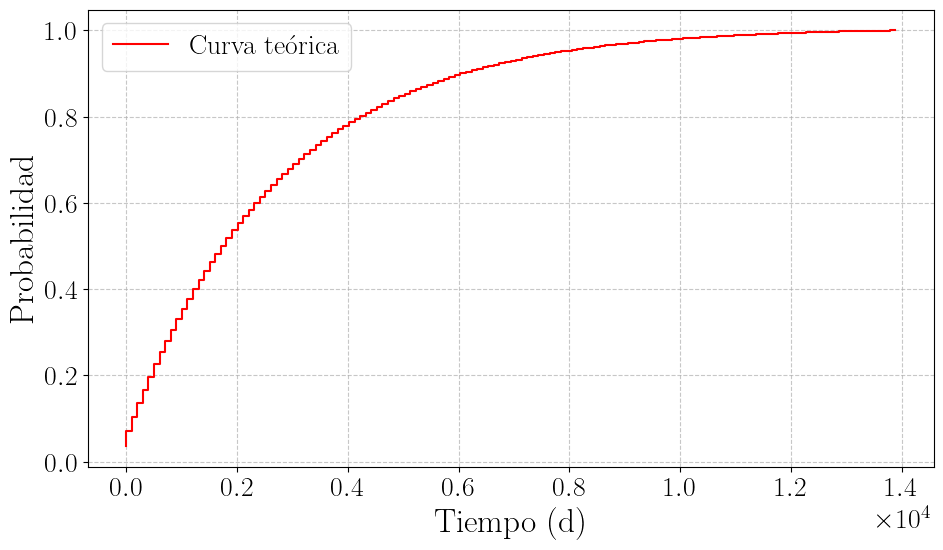

In [241]:
CoDecay = decay(period=Delta_t, gamma=gamma)



FDA_t = np.cumsum(CoDecay.P_norm(CoDecay.times))



fig, ax = plot_template(
    x_label="Tiempo (d)",
    y_label="Probabilidad",
)



ax.plot(CoDecay.times, FDA_t, label="Curva teórica", color="red", ds="steps")



ax.legend()


fig.show()

FDA_t[2]

Se genera el objeto que simula a con el método Montecarlo


In [242]:
# Función para simular el decaimiento de los núcleos
def simular_decaimiento(model, N):
    # Inicializamos el número de núcleos restantes y el tiempo actual
    success = 0
    tiempos = model.times  # Lista para almacenar los tiempos de decaimiento
    decaimientos = np.zeros(
        len(model.times)
    )  # Lista para almacenar el número de decaimientos

    # Ejecutamos la simulación tipo Montecarlo
    for event in range(N):
        r = rn.random()
        for case in np.arange(1, len(tiempos)):
            if r >= FDA_t[case - 1] and r < FDA_t[case]:
                success = case
                break
        decaimientos[success] += 1
    return tiempos, decaimientos


# test
if False:
    _, decaimientos = simular_decaimiento(CoDecay, 1000)
    print(decaimientos)
    print(np.sum(decaimientos))

C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\1039384515.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


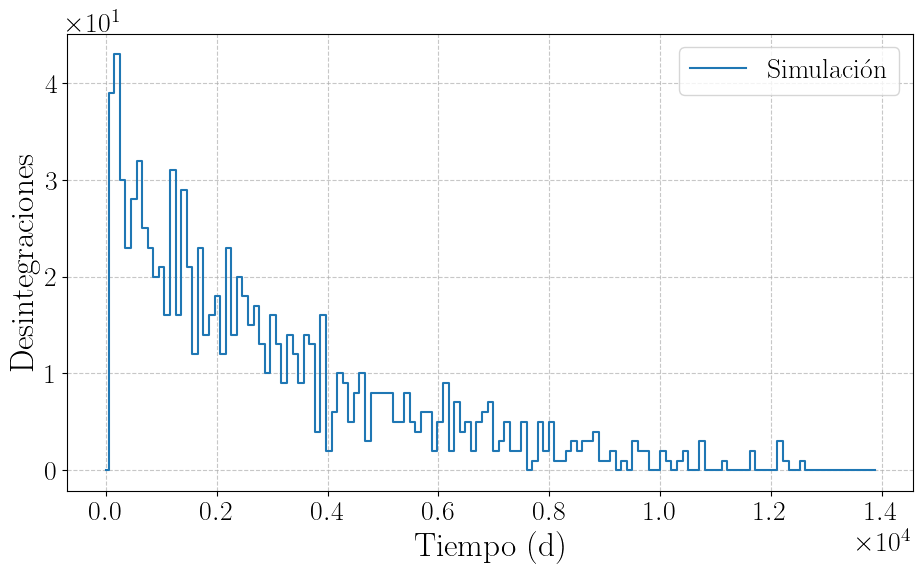

In [243]:
tiempos, decaimientos = simular_decaimiento(CoDecay, 1000)

fig, ax = plot_template(y_label="Desintegraciones", x_label="Tiempo (d)")
ax.plot(tiempos, decaimientos, ds="steps-mid", label="Simulación")
ax.legend()
fig.show()

### 6. Comparación Decaimientos


Se compara la gráfica $S(t)$ normalizada con la experimental previa pero de los sobrevivientes.


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\238174273.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


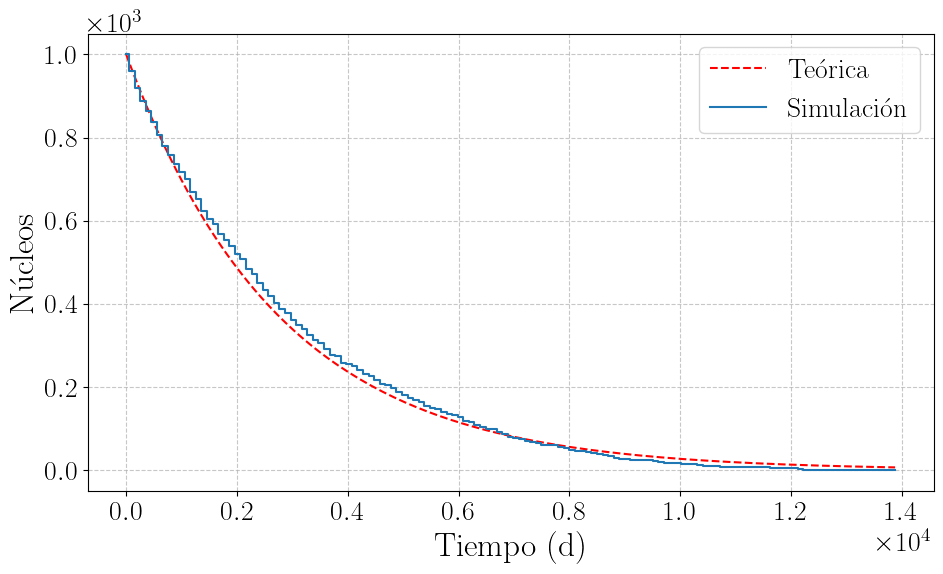

In [244]:
sobreviven = [1000 - decaidos for decaidos in np.cumsum(decaimientos)]
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, 1000 * CoDecay.S(tiempos), color="red", ls="--", label="Teórica")
ax.plot(tiempos, sobreviven, ds="steps-mid", label="Simulación")

ax.legend()
fig.show()

### 7. con varios núcleos $N_0$


Requerimos compararlo con los métodos previos y las diferentes cantidades de $N_0$

- $10^2$
- $10^3$
- $10^6$
- $10^8$


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\2572497782.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


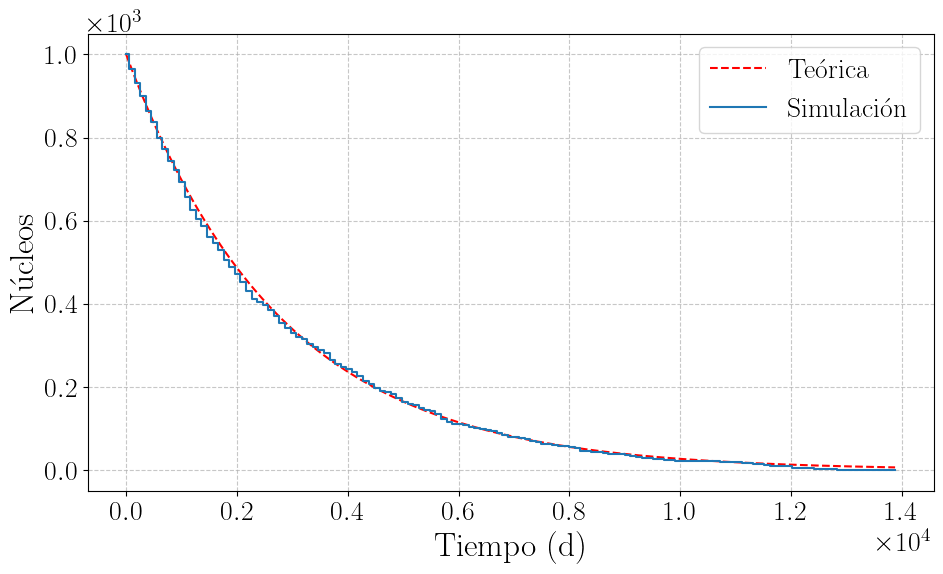

In [245]:
N = 1000
tiempos, decaimientos = simular_decaimiento(CoDecay, N)

sobreviven = [N - decaidos for decaidos in np.cumsum(decaimientos)]
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, N * CoDecay.S(tiempos), color="red", ls="--", label="Teórica")
ax.plot(tiempos, sobreviven, ds="steps-mid", label="Simulación")

ax.legend()
fig.show()

## Parte II: Distribución Binomial Núcleo por Núcleo


Se responderán a los resultados de la simulación de la desintegración nuclear como distribución binomial


### Función de Probabilidad Acumulativa


Se crea el objeto de que permite generar el modelo de probabilidad de nuestro caso binomial


In [246]:
class binomial:
    """Modelo de probabilidad binomial para N núcleos.
    Ingrese la probabilidad y calcule con una cantidad
    cualquiera aquellos que se desintegran y los que no.
    """

    def __init__(self, gamma, period):
        """Genera la probabilidad unitaria.

        Args:
            p (float): probabilidad unitaria
        """
        self.gamma = gamma
        self.period = period
        self.p = gamma * period
        self.hist = np.zeros(2)
        self.cases = np.array([0, 1])  # Las dos posibilidades

    def prob(self, x):
        """Función de densidad de probabilidad para N = 1

        Args:
            x (float): variable aleatoria.

        Returns:
            float, int: 0 no se desintegró; 1 sí se desintegró
        """
        if x < 0 or x > 1:
            return 0
        elif x == 0:
            return 1 - self.p
        elif x == 1:
            return self.p

    def exp(self, hist):
        for i in range(hist):
            r = rn.random()
            if self.prob(r) == 0:
                self.hist[0] += 1
            elif self.prob(r) == 1:
                self.hist[1] += 1

        return self.hist


# test
if False:
    pass

Se genera la función acumulativa del binomial. Como solo son dos casos (sobrevive o desintegra), luego es un hisograma sencillo.


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\3611578454.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


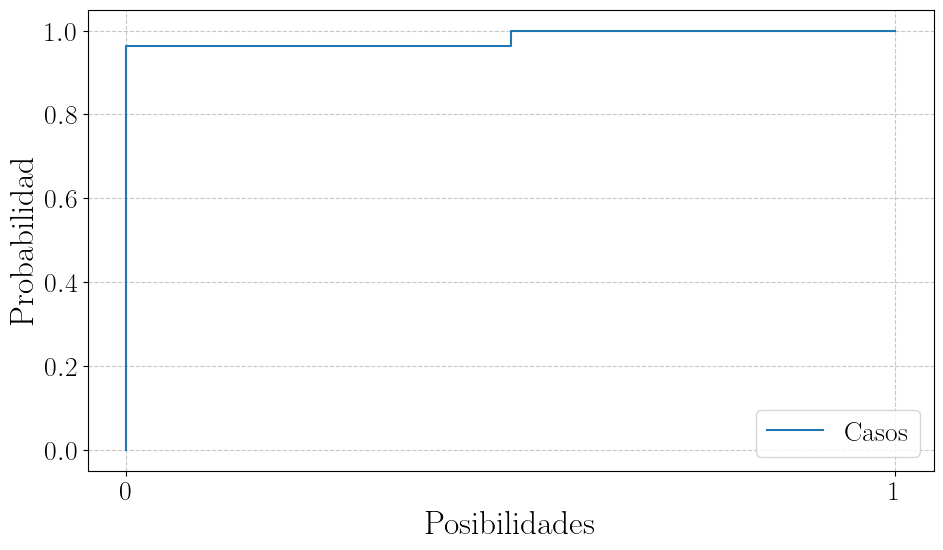

In [247]:
# Función acumulativa
Co_bin = binomial(gamma, Delta_t)
FDA_bin = np.cumsum([Co_bin.prob(case) for case in Co_bin.cases])
FDA_bin = np.concatenate(([0], FDA_bin))

fig, ax = plot_template(y_label="Probabilidad", x_label="Posibilidades")
ax.plot(np.concatenate(([0], Co_bin.cases)), FDA_bin, label="Casos", ds="steps-mid")
plt.xticks(Co_bin.cases)
ax.legend()
fig.show()

Ahora simulamos la situación de decaimiento. Cada núcleo decidirá si decae o no con esta distribución.


In [248]:
def simular_decaimiento_binomial(model, N):
    # Inicializamos el número de núcleos restantes y el tiempo actual
    N_restante = N
    tiempo = 0  # Tiempo en segundos
    tiempos = []  # Lista para almacenar los tiempos de decaimiento
    decaimientos = []  # Lista para almacenar el número de decaimientos

    # Ejecutamos la simulación
    while tiempo < model.end and N_restante > 0:  # simulamos paso del tiempo
        num_decaimientos = 0
        for _ in range(N_restante):  # simulamos cada particula
            r = rn.random()  # probabilidad
            if r > FDA_bin[1]:  # ¿decayó?
                num_decaimientos += 1  # se suma

        # Actualizamos el número de núcleos restantes
        N_restante -= num_decaimientos

        # Guardamos el tiempo y el número de decaimientos
        tiempos.append(tiempo)
        decaimientos.append(num_decaimientos)

        # Actualizamos el tiempo
        tiempo += model.period

    return tiempos, decaimientos


if True:
    _, decaimientos = simular_decaimiento_binomial(CoDecay, 1000)
    print(decaimientos)
    print(np.sum(decaimientos))

[34, 37, 22, 27, 41, 30, 34, 26, 28, 25, 24, 22, 27, 20, 22, 14, 22, 15, 14, 25, 11, 18, 19, 16, 12, 15, 12, 14, 16, 12, 10, 14, 8, 13, 14, 8, 8, 7, 7, 5, 11, 6, 6, 8, 11, 8, 1, 15, 4, 5, 8, 6, 4, 4, 6, 4, 4, 5, 5, 5, 8, 3, 5, 2, 5, 6, 4, 2, 3, 3, 2, 4, 3, 0, 2, 5, 4, 3, 4, 1, 1, 3, 0, 0, 0, 4, 3, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
992


Ahora, se grafican en el histograma para compararlos con los previos.


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\3682326966.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


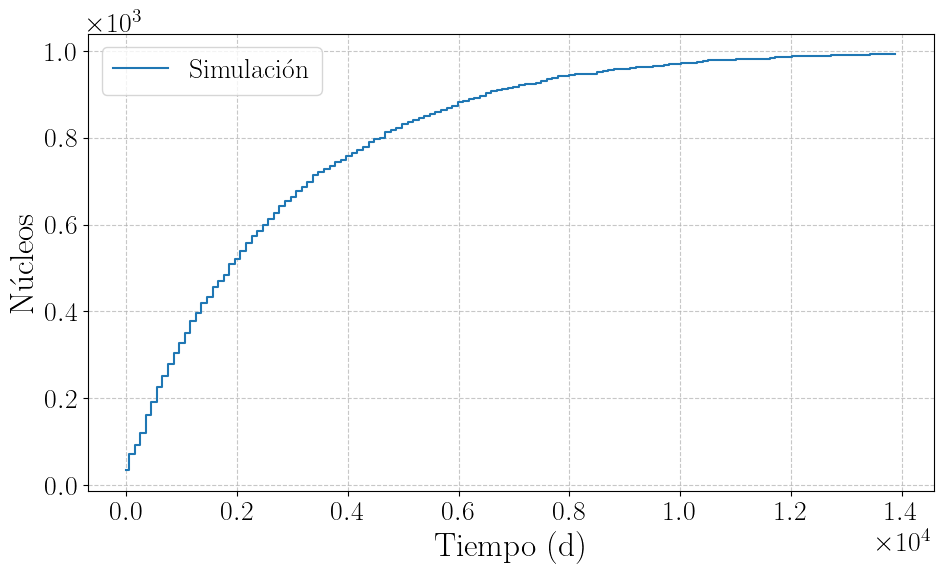

In [249]:
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, np.cumsum(decaimientos), ds="steps-mid", label="Simulación")
ax.legend()
fig.show()

C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\1187321689.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


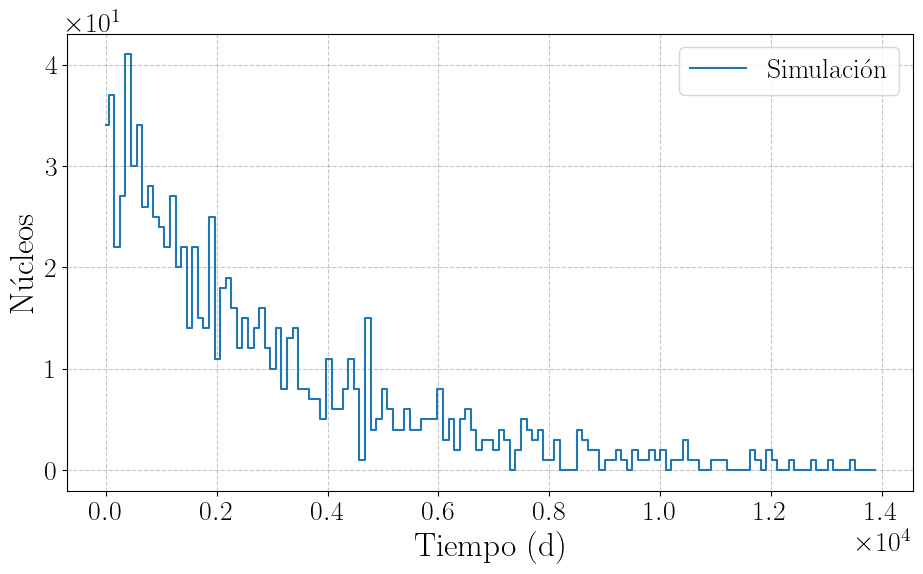

In [250]:
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, decaimientos, ds="steps-mid", label="Simulación")
ax.legend()
fig.show()

### 12. Núcleos supervivientes


Se cuentan los supervivientes


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\1327197183.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


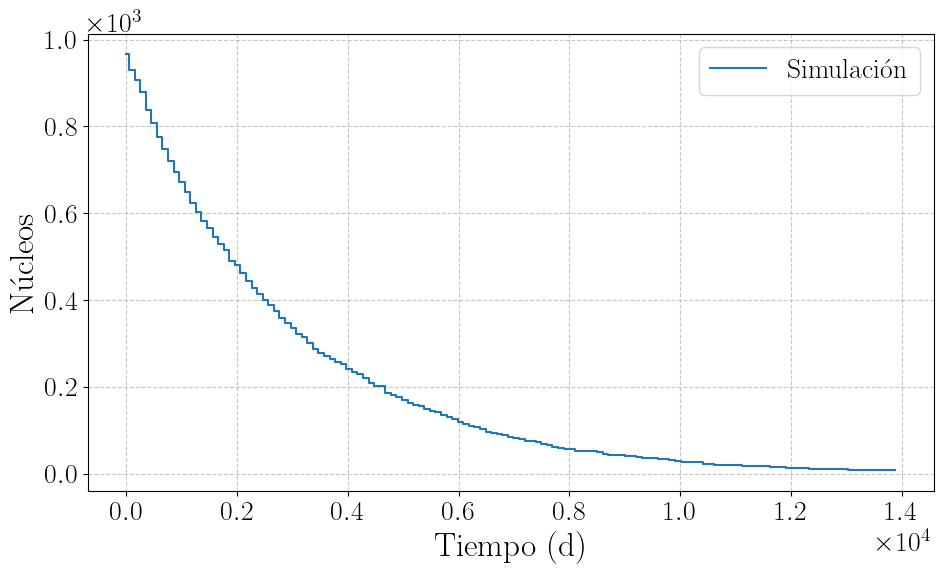

In [251]:
sobreviven = [1000 - decaidos for decaidos in np.cumsum(decaimientos)]
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, sobreviven, ds="steps-mid", label="Simulación")
ax.legend()
fig.show()

### 13. Comparación métodos


Requerimos compararlo con los métodos previos y las diferentes cantidades de $N_0$

- $10^2$
- $10^3$
- $10^6$
- $10^8$


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\3256855776.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


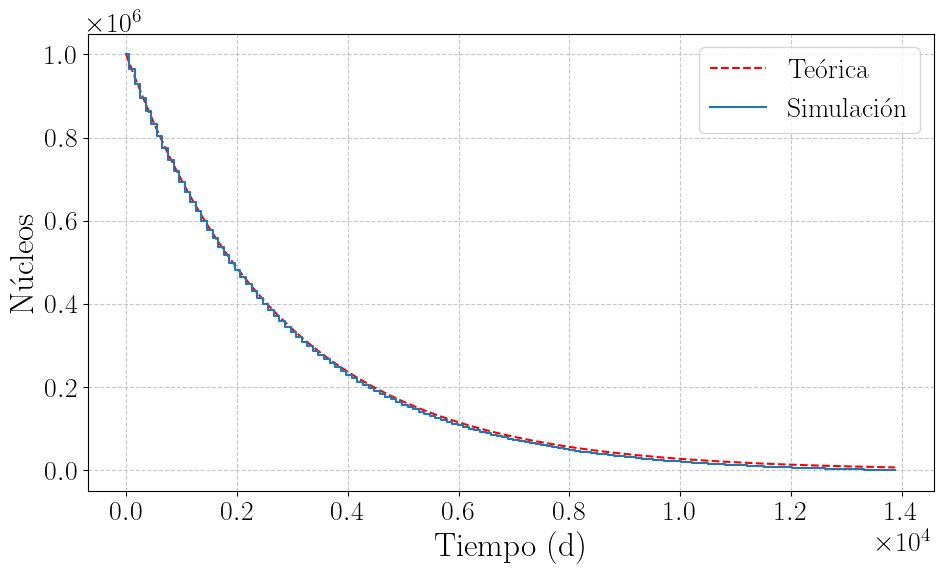

In [254]:
N = 1000000
tiempos, decaimientos = simular_decaimiento(CoDecay, N)

sobreviven = [N - decaidos for decaidos in np.cumsum(decaimientos)]
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, N * CoDecay.S(tiempos), color="red", ls="--", label="Teórica")
ax.plot(tiempos, sobreviven, ds="steps-mid", label="Simulación")

ax.legend()
fig.show()

### 14. Comparación Teórica


Se utiliza la gráfica primera con esta comparadas para N = 1000


C:\Users\pinzo\AppData\Local\Temp\ipykernel_17276\4204824348.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


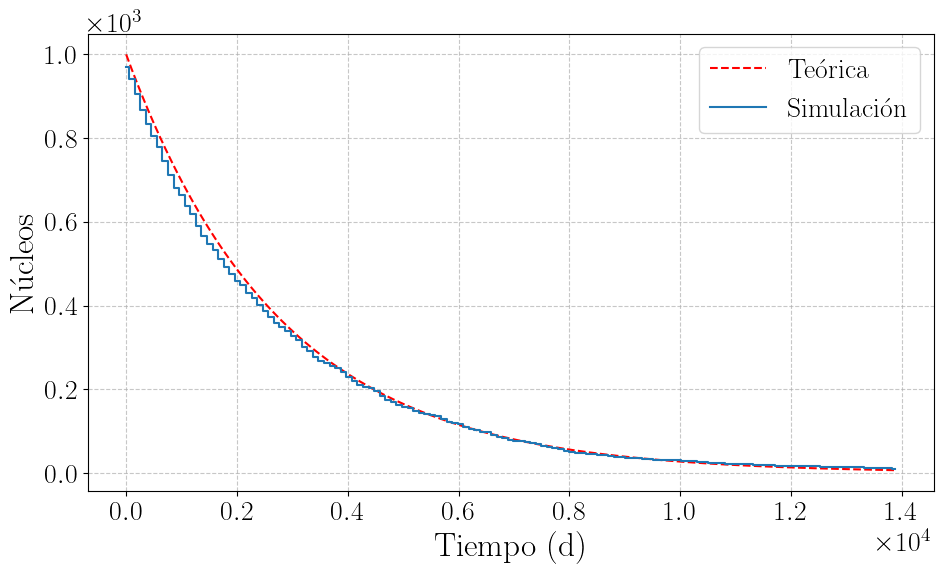

In [ ]:
fig, ax = plot_template(
    y_label="Núcleos",
    x_label="Tiempo (d)",
)
ax.plot(tiempos, 1000 * CoDecay.S(tiempos), color="red", ls="--", label="Teórica")
ax.plot(tiempos, sobreviven, ds="steps-mid", label="Simulación")
ax.legend()
fig.show()

## Referencias


- Indice de todo lo nuclear super bueno
  Nuclear Data – Table – Laboratoire National Henri Becquerel. (2016). Lnhb.fr. http://www.lnhb.fr/home/nuclear-data/nuclear-data-table/

- Exacto para el 60
  http://www.lnhb.fr/nuclides/Co-60_tables.pdf

- ToxFAQsTM: Cobalto (Cobalt) | ToxFAQ | ATSDR. (2023, February 2). Cdc.gov. https://www.atsdr.cdc.gov/es/toxfaqs/es_tfacts33.html#:~:text=El%2060Co%20(l%C3%A9ase%20cobalto,la%20investigaci%C3%B3n%20m%C3%A9dica%20y%20cient%C3%ADfica.

- 14.6: Vida media y cinética de desintegración radiactiva. (2022, October 30). LibreTexts Español. https://espanol.libretexts.org/Quimica/Qu%C3%ADmica_General/Mapa:_Qu%C3%ADmica_General:_Principios,_Patrones_y_Aplicaciones_%28Averill%29/14:_Cin%C3%A9tica_qu%C3%ADmica/14.06:_Vida_media_y_cin%C3%A9tica_de_desintegraci%C3%B3n_radiactiva?form=MG0AV3
